# DATA CLEANING AND PREPROCESSING

### TL;DR
**This note book cleanses the job advert data set and prepares it to make it suitable as input into any classification model. Some level of feature engineering like column merging,1-hot-encoding where perform. This was followed by text processing - tokenisation, lemmatisation et al. Finally, the data set was split into test (70%), validation (15%) and test (15%) sets. The 3 data splits where then saved individually to disk. I built two sets of features (each having it own train/val/test splits (see rational further down). One merged the `abstract` and the `content` variables togther form for a single text variable. The seocnd used only the abstract variable as the only text based variable.**

In [4]:
# suspend all notebook warnings and enable auto reload
import warnings
import sys
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
sys.path.append('../src/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pickle
import pandas as pd
import tensorflow as tf
import numpy as np
import missingno as msno
import nltk
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_theme()
%matplotlib inline

In [6]:
#custom module import
from helper import data_prep_pipeline, check_missing_distribution 
from helper import plot_bar, plot_top_words 
from constants import *

In [7]:
# reading in the data and making a copy
data = pd.read_json('../data/raw/ads-50k.json', lines=True)
print(data.shape)
data_copy = data.copy()
#data_copy = data_copy.sample(frac=1).reset_index(drop=True)
data_copy.head(2)

(50000, 5)


,id,title,abstract,content,metadata
0,38915469,Recruitment Consultant,We are looking for someone to focus purely on ...,<HTML><p>Are you looking to join a thriving bu...,{'standout': {'bullet1': 'Join a Sector that i...
1,38934839,Computers Salesperson - Coburg,Passionate about exceptional customer service?...,<HTML><p>&middot;&nbsp;&nbsp;Casual hours as r...,{'additionalSalaryText': 'Attractive Commissio...


### Unrolling the `metedata` column and putting each child element in its own column.

In [8]:
data_copy = data_copy.join(pd.json_normalize(data_copy['metadata']))
column_renaming = {column: '_'.join(column.split('.')) for column in data_copy.columns}
data_copy.rename(columns=column_renaming, inplace=True)
data_copy.drop('metadata', inplace=True, axis=1)
data_copy.head(2)

,id,title,abstract,content,additionalSalaryText,standout_bullet1,standout_bullet2,standout_bullet3,classification_name,subClassification_name,location_name,workType_name,area_name,suburb_name
0,38915469,Recruitment Consultant,We are looking for someone to focus purely on ...,<HTML><p>Are you looking to join a thriving bu...,commission,Join a Sector that is considered Recession Pro...,Excellent opportunity for Career Progression ...,Make a Diference whilst earning Money and havi...,Education & Training,Other,Sydney,Full Time,NaN,NaN
1,38934839,Computers Salesperson - Coburg,Passionate about exceptional customer service?...,<HTML><p>&middot;&nbsp;&nbsp;Casual hours as r...,Attractive Commission - Uncapped Earning Poten...,NaN,NaN,NaN,Retail & Consumer Products,Retail Assistants,Melbourne,Casual/Vacation,Northern Suburbs,Coburg


### Text cleaning tokenization and lemmatization
The `classification_name` column will be used as the target variable in the classification model, so I want to keep it out of any preprocessing.

In [9]:
# keep the potential target variable apart
target = data_copy['classification_name']
data_copy.drop('classification_name', axis=1, inplace=True)
data_copy = data_prep_pipeline(data_copy)
# add the target variable back after pre-processing steps
data_copy['classification_name'] = target
data_copy.head(2)

,id,title,abstract,content,additionalSalaryText,standout_bullet1,standout_bullet2,standout_bullet3,subClassification_name,location_name,workType_name,area_name,suburb_name,classification_name
0,38915469,recruitment consultant,looking someone focus purely recruit permanent...,looking join thrive business reward hard work ...,commission,join sector consider recession proof,excellent opportunity career progression withi...,make diference whilst earn money fun,,sydney,full time,NaN,NaN,Education & Training
1,38934839,computer salesperson coburg,passionate exceptional customer service excite...,casual hours require transition part time full...,attractive commission uncapped earn potential,NaN,NaN,NaN,retail assistant,melbourne,casual vacation,northern suburb,coburg,Retail & Consumer Products


In [10]:
data.content[0]

'<HTML><p>Are you looking to join a thriving business that will reward your hard work whilst you make a difference to Children’s lives?</p><p><strong>The Role:</strong> We are looking for someone to focus purely on recruiting Permanent staff in the Early Childhood Educaton Sector. The role will include:</p><ul><li>Building relationships with range of existing and prospective clients</li><li>Identify their issues and help provide the solution</li><li>Attending client visits and understanding client requirements</li><li>Representing Pulse Child Care Crew as an ambassador at career fairs and other external events</li><li>Managing recruitment processes to deliver monthly targets</li><li>Developing and executing your own candidate development strategy</li><li>Coordinating resources to ensure all vacancies are properly worked</li></ul><p> </p><p><strong>The Benefits</strong></p><ul><li>Competitive salary and commission structure, with uncapped earning potential.</li><li>Have your experience 

In [11]:
data_copy.content[0]

'looking join thrive business reward hard work whilst make difference child life role looking someone focus purely recruit permanent staff early childhood educaton sector role include building relationship range exist prospective client identify issue help provide solution attending client visit understanding client requirement represent pulse child care crew ambassador career fair external event manage recruitment process deliver monthly target developing executing candidate development strategy coordinate resource ensure vacancy properly work benefit competitive salary commission structure uncapped earn potential experience success recognise key player business everyone hear encourage offer opinion regular incentive include expense trip team building days financial reward celebratory meal eligible day 1 quarterly lunch club expense pay friday afternoon posh restaurant part socially active supportive team great balance competitive hard work plenty fun investor people consistent focus 

### Job Category Distrubution
**As hinted above, the `classification_name` will be used as the target variable for a classifcation model. The plot below shows the distrubtion of the categories in this variable. It's obvious that there is a huge class inbalance. For example, the `self employment` category has only a tiny fraction of the number of samples bosted by `ICT`. If this data is used without any intervention to build a classifier, such a model will be skewed towards the dominant categories. There are a number of techniques that could be used to correct this - getting more data, oversampling minority classes, undersampling the dominant classes, synthetic data generation e.t.c. To keep things simple, I will only include a subsample of the categories in the classification task. I decided to only include classes with sample number of atleast `30%` of the number of samples in the most dominant class (`ICT`).**

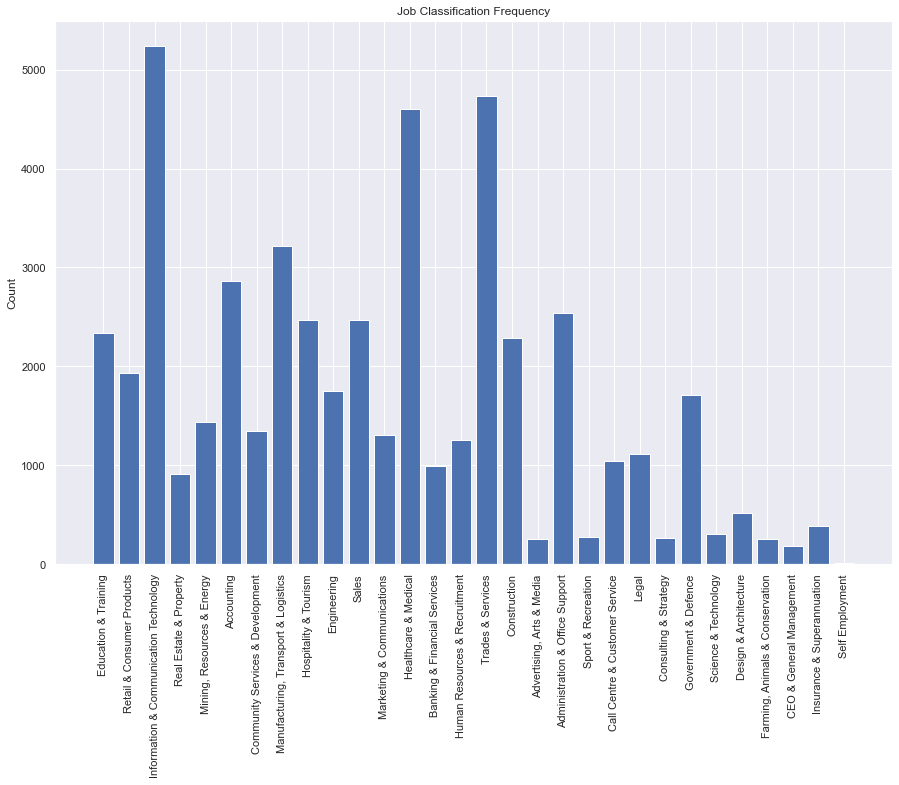

In [12]:
classification_counts = dict(Counter(data_copy['classification_name']))
categories, counts = zip(*((cat, num) for cat, num in classification_counts.items()))
plot_bar(categories, counts, 'Job Classification Frequency', '', 'Count', 90)

**Following through on the decision made above, the job classification categories have now been reduced from `30` to `12`. The down side of this is that, in production, the eventual classification model built on top of the data will not be capable of recognising classes from the dropped categories.**

In [13]:
dominant_class_count = max(classification_counts.values())
selected_categories = [category for category in classification_counts if classification_counts[category] >= dominant_class_count*0.33]
selected_categories

['Education & Training',
 'Retail & Consumer Products',
 'Information & Communication Technology',
 'Accounting',
 'Manufacturing, Transport & Logistics',
 'Hospitality & Tourism',
 'Engineering',
 'Sales',
 'Healthcare & Medical',
 'Trades & Services',
 'Construction',
 'Administration & Office Support']

In [14]:
data_subsample = data_copy[data_copy['classification_name'].isin(selected_categories)]
data_subsample.head(2)

,id,title,abstract,content,additionalSalaryText,standout_bullet1,standout_bullet2,standout_bullet3,subClassification_name,location_name,workType_name,area_name,suburb_name,classification_name
0,38915469,recruitment consultant,looking someone focus purely recruit permanent...,looking join thrive business reward hard work ...,commission,join sector consider recession proof,excellent opportunity career progression withi...,make diference whilst earn money fun,,sydney,full time,NaN,NaN,Education & Training
1,38934839,computer salesperson coburg,passionate exceptional customer service excite...,casual hours require transition part time full...,attractive commission uncapped earn potential,NaN,NaN,NaN,retail assistant,melbourne,casual vacation,northern suburb,coburg,Retail & Consumer Products


**The plot below shows the distribution of classes in the reduce data set (`data_subsample`)**

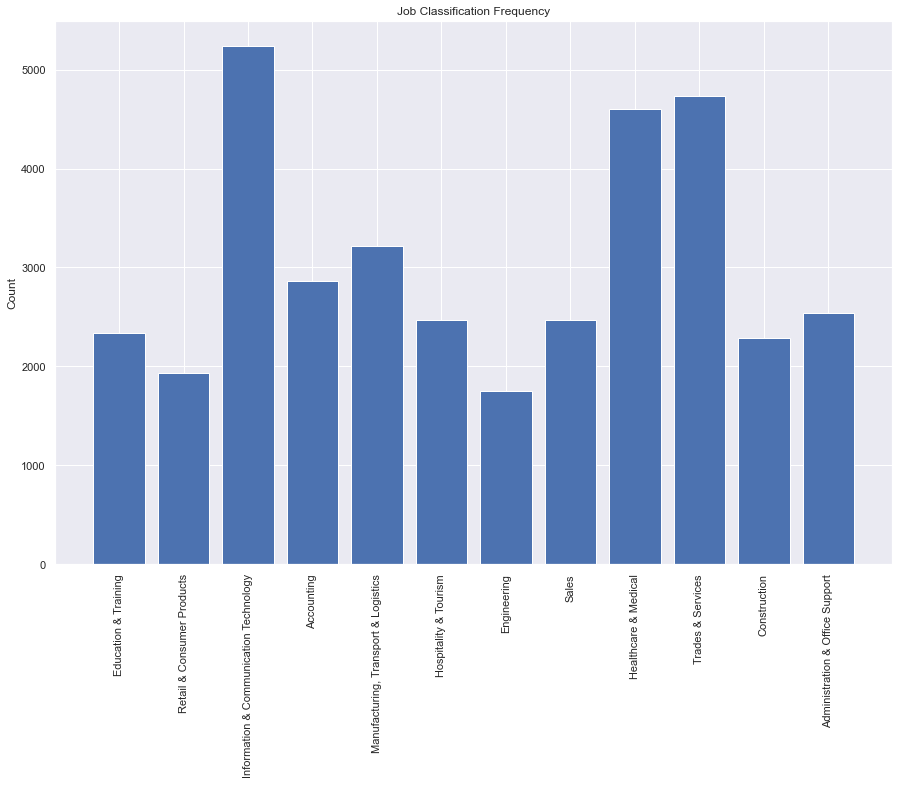

In [15]:
classification_counts = dict(Counter(data_subsample['classification_name']))
categories, counts = zip(*((cat, num) for cat, num in classification_counts.items()))
plot_bar(categories, counts, 'Job Classification Frequency', '', 'Count', 90)

### FEATURE SELECTION & ENGINEERING

**As mentioned above, I decided to build two set of features (and by extension models)**:
- **One in which both the job `content` and the `abstract` variables are merged together to form a single text based variable called `description`**.
- **The second in which the `content` variable was dropped altogether and the based feature only came from the `abstract` variable**.

**The rational behind this is that a model could be built to suggest a job sector to a job poster just after writing the `abstract` rather than waiting for the detailed content of the job to be entered. If this model is not accurate enough, a more accurate model that includes the job `content` feature could then be leverage to make a final suggestion to the job poster after entering the full job dicription(`content`).**

In [16]:
data_subsample['description'] = data_subsample['abstract'] + ' ' + data_subsample['content'] # combine abstract & content 
#data_subsample['description'] = data_subsample['abstract'] # if to use only the abstract
data_subsample['target'] = data_copy['classification_name']
data_subsample.head(2)

,id,title,abstract,content,additionalSalaryText,standout_bullet1,standout_bullet2,standout_bullet3,subClassification_name,location_name,workType_name,area_name,suburb_name,classification_name,description,target
0,38915469,recruitment consultant,looking someone focus purely recruit permanent...,looking join thrive business reward hard work ...,commission,join sector consider recession proof,excellent opportunity career progression withi...,make diference whilst earn money fun,,sydney,full time,NaN,NaN,Education & Training,looking someone focus purely recruit permanent...,Education & Training
1,38934839,computer salesperson coburg,passionate exceptional customer service excite...,casual hours require transition part time full...,attractive commission uncapped earn potential,NaN,NaN,NaN,retail assistant,melbourne,casual vacation,northern suburb,coburg,Retail & Consumer Products,passionate exceptional customer service excite...,Retail & Consumer Products


**Droping irrelevant/already process columns, while doing that I will also shorten `Information & Communication Technology` to ICT in the target column**

In [17]:
data_subsample.drop(['id', 'abstract', 'content', 'classification_name'], axis=1, inplace=True)
#data_subsample["target"].replace({'Information & Communication Technology': 'ICT'}, inplace=True)
data_subsample.head(2)

,title,additionalSalaryText,standout_bullet1,standout_bullet2,standout_bullet3,subClassification_name,location_name,workType_name,area_name,suburb_name,description,target
0,recruitment consultant,commission,join sector consider recession proof,excellent opportunity career progression withi...,make diference whilst earn money fun,,sydney,full time,NaN,NaN,looking someone focus purely recruit permanent...,Education & Training
1,computer salesperson coburg,attractive commission uncapped earn potential,NaN,NaN,NaN,retail assistant,melbourne,casual vacation,northern suburb,coburg,passionate exceptional customer service excite...,Retail & Consumer Products


### Visualizing and dealing with missing samples

**With missing values, I only concerned myself with how they affect the target variable (job sector). As can be seen in the grid plot in the cell below, this missings are somewhat evenly distributed accross the categories in the target variable. To deal with these entries, I used one-hot-code to signify the missing for each variable. Rather than throwing away the texts from the non-mission rows, I concatenated then with the single text-based feature (`description`).**

<AxesSubplot:>

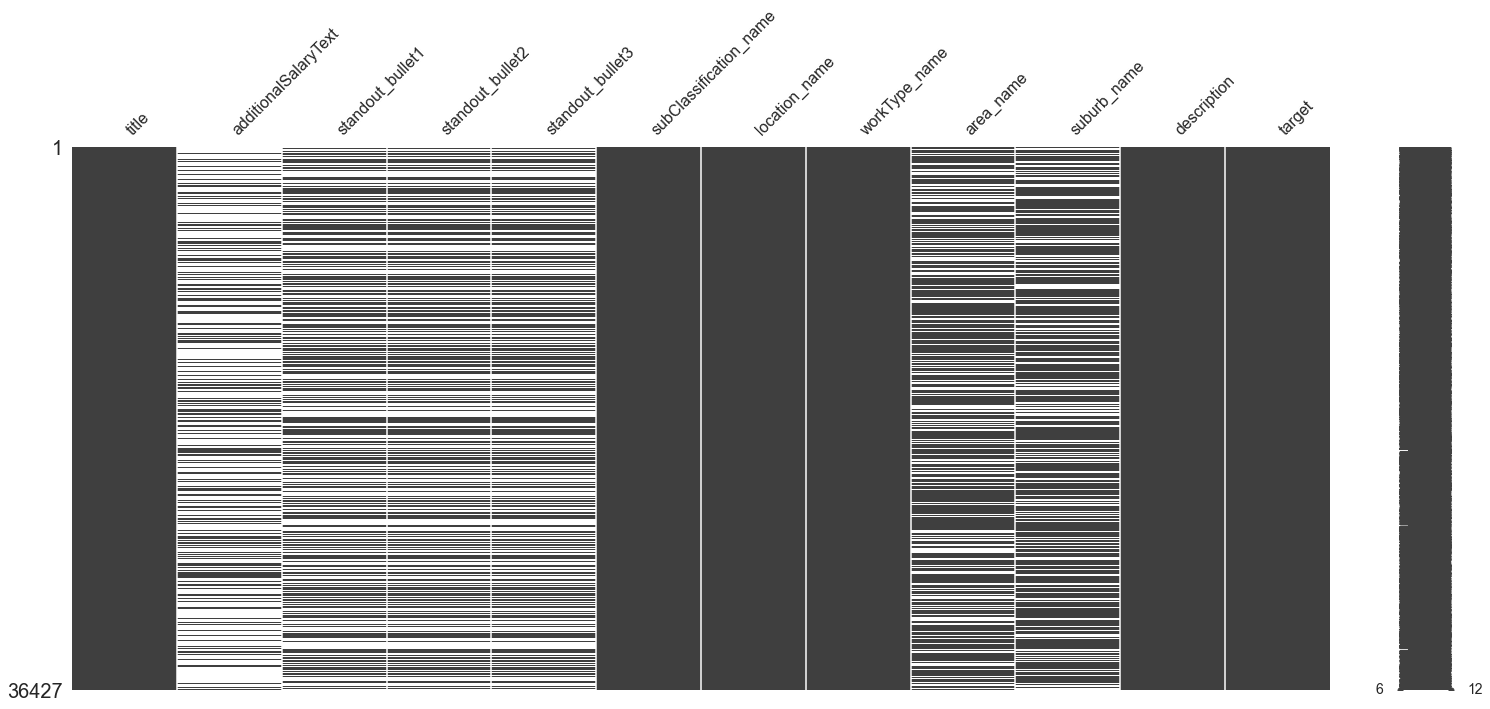

In [18]:
msno.matrix(data_subsample)

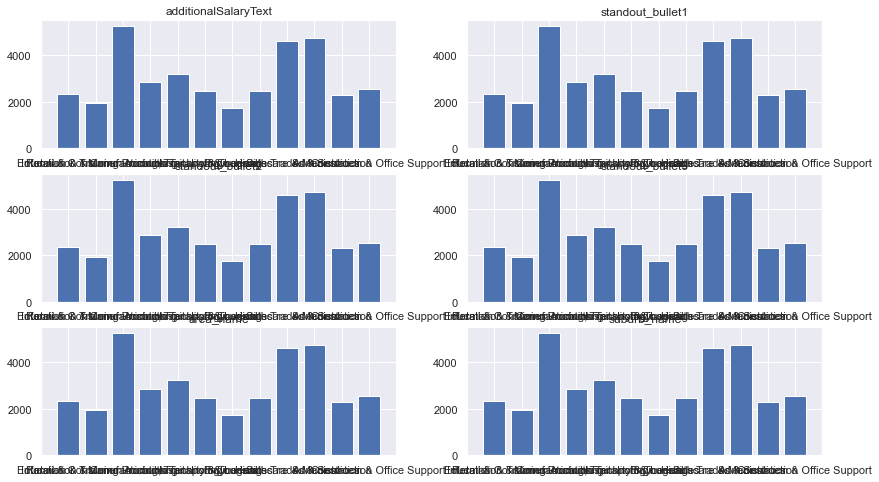

In [19]:
fig = plt.figure()
#fig.set_size_inches(18.5, 15.5)
fig.set_size_inches(14, 8)
cols_with_missing_data = ['additionalSalaryText', 
                          'standout_bullet1', 
                          'standout_bullet2', 
                          'standout_bullet3', 
                          'area_name', 
                          'suburb_name']


plt.rc('font', **FONT)

for i, col in enumerate(cols_with_missing_data, 1):
    ax = fig.add_subplot(3, 2, i)
    value, count = check_missing_distribution(data_subsample, cols_with_missing_data[i-1], 'target')
    ax.bar(value, count)
    ax.set_title(col)
    
plt.show()

In [20]:
data_subsample_copy = data_subsample.fillna(' ')

In [21]:
data_subsample_tmp = data_subsample.copy()
data_subsample['description'] = data_subsample_copy[['description', 'additionalSalaryText', 
                                                'standout_bullet1', 
                                                'standout_bullet2', 
                                                'standout_bullet3'
                                               ]].astype(str).agg(' '.join, axis=1)


In [22]:
data_subsample['description'] = data_subsample['description'].str.strip()
data_subsample['additionalSalaryText'] = data_subsample['additionalSalaryText'].apply(lambda x: 1 if x else 0 )
list(data_subsample['description'])[20]

'process worker require site ingleburn early morning early afternoon shift immediate start onsite parking toll people currently seeking reliable motivate process worker site base ingleburn role casual role require experience process worker particular looking new starter able use initiative complete manual task part daily duty duty involve limited process work picking packing prior meat process work experience prefer rf scanning experience desirable manual lift sortation freight experience require general housekeeping require previous warehouse experience highly beneficial working towards daily kpi consider role must posse following previous warehouse experience essential able work rotate roster pm start times reliable punctual use initiative able work fast pace environment high level accuracy willing undergo national police check able start immediately benefit look forward working company values safety honesty integrity well organise facility promote safe friendly environment south wes

In [23]:
data_subsample['additionalSalaryText'] = data_subsample['additionalSalaryText'].notnull().astype(int)
data_subsample['standout_bullet1'] = data_subsample['standout_bullet1'].notnull().astype(int)
data_subsample['standout_bullet2'] = data_subsample['standout_bullet2'].notnull().astype(int)
data_subsample['standout_bullet3'] = data_subsample['standout_bullet3'].notnull().astype(int)

I will drop the `title` and `subCLassification_name`, I believe this columns could leakage the class information to a model

### Dropped Variables:
- **`id`:** this is a pretty useless variable as far as building ML model is concerned, this is simply because of the uniqueness of its entries accross the rows in the data set.
- **`title`:** there is a strong correlation between this variable and the target variable, including it will affect the generalization of the evetual model as might leak information to the model during training.
- **`subCLassification_name`:** dropped for the same reasoned as `title`

In [24]:
data_subsample.drop(['title', 'subClassification_name'], axis=1, inplace=True)

### Dummified Variables:
**I 1-hot-code the `location_name`,  `workType_name`, `area_name`, and `suburb_name` as the number of categories in the each of of them sizeable. Even at that, this expanded the feature space by over 1500.**

In [25]:
one_hot_columns = ['location_name', 'workType_name', 'area_name', 'suburb_name']
data_subsample = pd.get_dummies(data_subsample, prefix=one_hot_columns, columns=one_hot_columns)

### Word count distribution in the `description` variable
**With all the hard work that have been done above, we are now left with only one text based variable (`description`). It consists of all the text concatenation done using the following variables:**
- `abstract`
- `additionalSalaryText` 
- `standout_bullet1` 
- `standout_bullet2`
- `standout_bullet3`
- `content` (for the set that incuded it)
**Here is the document lenght distribution of this new variable  across `500` data samples**

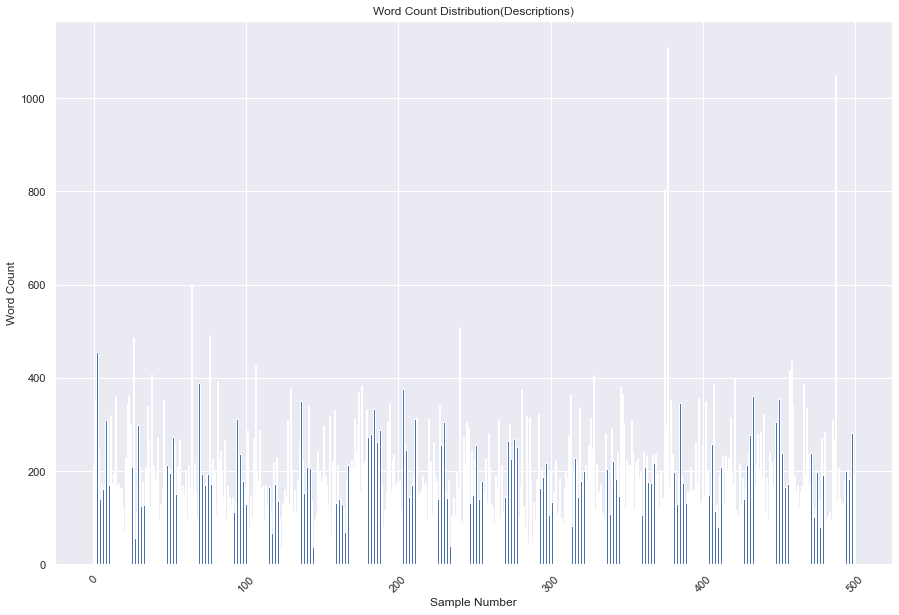

In [26]:
samples = data_subsample.sample(500)['description']
sample_num, sample_len = zip(*[(i, len(sample.split())) for i, sample in  enumerate(samples)])
sample_num, sample_len
title = 'Word Count Distribution(Descriptions)'
x_label = 'Sample Number'
y_label = 'Word Count'
plot_bar(sample_num, sample_len, title, x_label, y_label, rotation=45)

### Word frequencies distrution in the `decription` column across the `3` dominant classes.

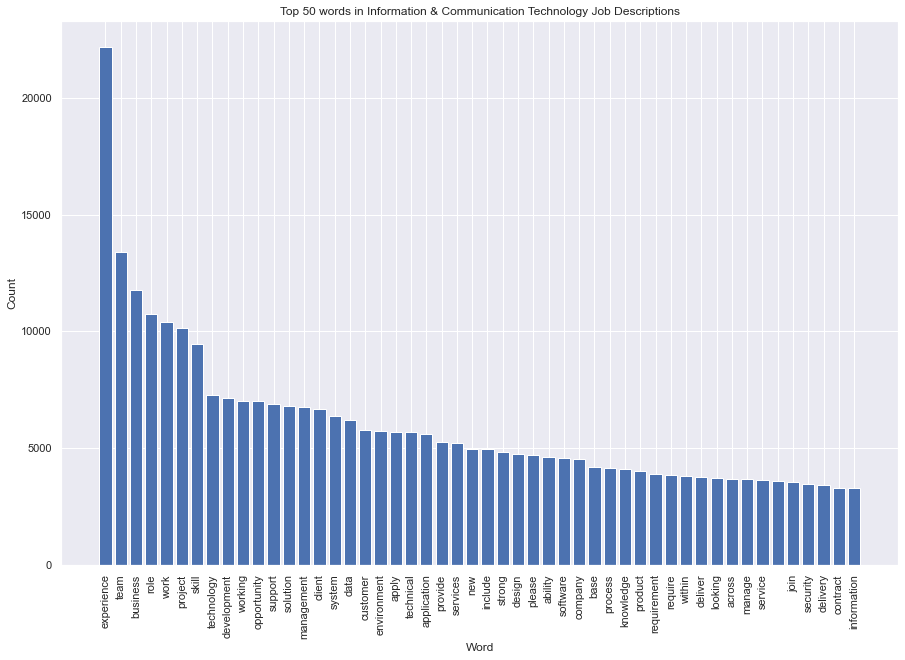

In [27]:
plot_top_words(data_subsample, 'Information & Communication Technology')

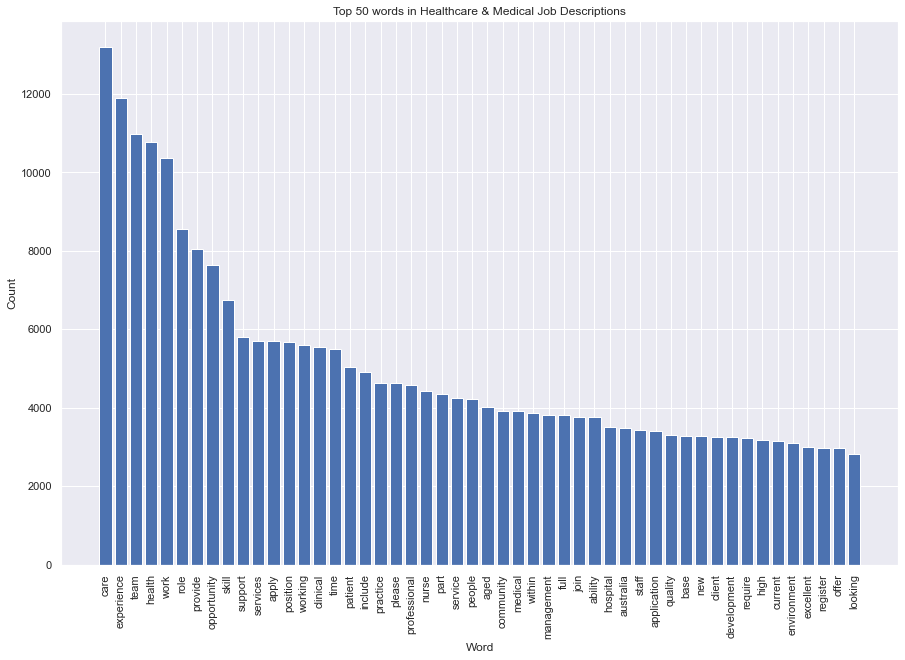

In [28]:
plot_top_words(data_subsample, 'Healthcare & Medical')

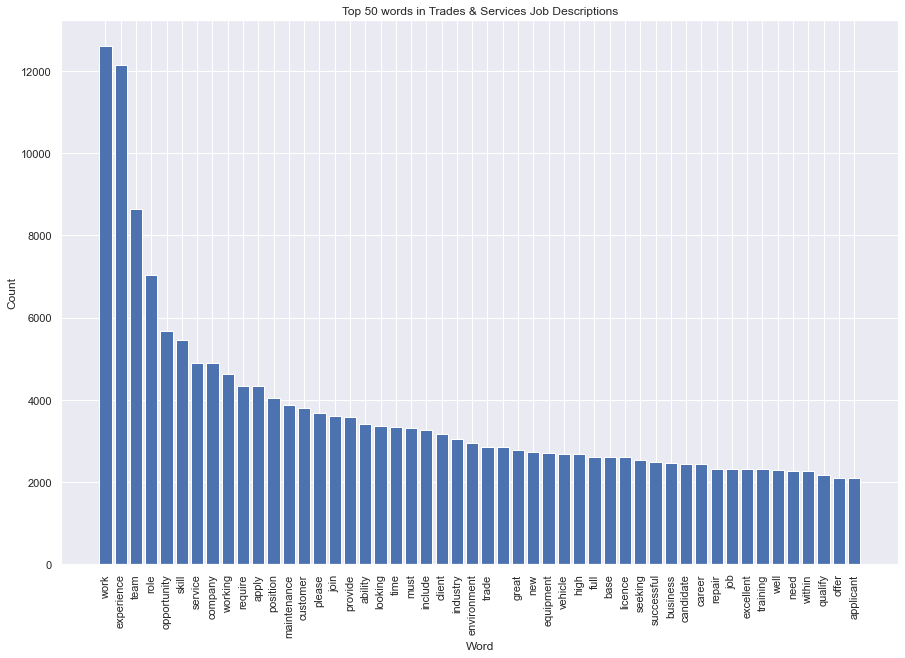

In [29]:
plot_top_words(data_subsample, 'Trades & Services')

### Coverting the `target` column to numerial and splitting the data into train (70%), val (15%) and test(15%)

In [30]:
data_subsample['target'] = data_subsample['target'].astype('category')
data_subsample['target'] = data_subsample['target'].apply(lambda x: LABEL_MAPPING[x])
train_df, val_test_df = train_test_split(data_subsample, test_size=0.3)

# further split the val_test_df into val_df and test_df
val_df, test_df = train_test_split(val_test_df, test_size=0.5)

In [31]:
train_df.shape, val_df.shape, test_df.shape

((25498, 2472), (5464, 2472), (5465, 2472))

### Saving the data for later reference

**Set one that excludes the text from the `content` variable**

In [32]:
# train_df.to_csv('../data/processed/train_df_excludes_content', index=False)
# val_df.to_csv('../data/processed/val_df_excludes_content', index=False)
# test_df.to_csv('../data/processed/test_df_excludes_content', index=False)

**Set two that includes the text from the `content` variable**

In [33]:


# train_df.to_csv('../data/processed/train_df_includes_content', index=False)
# val_df.to_csv('../data/processed/val_df_includes_content', index=False)
# test_df.to_csv('../data/processed/test_df_includes_content', index=False)